### Imports

In [1]:
%matplotlib notebook  
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
from pathlib import Path

# importing model and loss function
from model.alt_loss_A import Loss
from model.models_mjp_30Jan21 import BM_ACN_1_6L as Model

# importing training utility functions
#from model.training_kde import select_gpu, Results, trainNet
from functions.new_training_kde import select_gpu, Results, trainNet
from model.plots import dual_train_plots, replace_in_ax
from model.collectdata_poca_KDE import collect_data_poca
from functions.utils import vector_to_state_dict

# importing modified optimizers
from functions.new_optimizers import Adam, reversible_Adam, EpochEVE 

# shows GPU usage
!nvidia-smi

Mon Sep 20 01:28:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 33%   48C    P2    49W / 250W |   7448MiB / 12066MiB |     52%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

### Set up training parameters

In [2]:
# the output folder the results are stored in 
name   = 'example'

# note that baileyds is a symbolic link to a directory on share/lazy/
folder = 'baileyds/AllCNN/' + name
output = Path(folder)
output.mkdir(exist_ok=True)

n_epochs = 50
batch_size = 128 
learning_rate = 5e-5
# choose gpu to use (or cpu)
device = "cuda:2"

In [3]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

### Load data

In [4]:
train_loader = collect_data_poca('/share/lazy/will/data/June30_2020_80k_1.h5',
                            '/share/lazy/will/data/June30_2020_80k_3.h5',
                            batch_size=batch_size,
 #                           device=device,
                            masking=True,
                            shuffle=True,
                           ## slice = slice(0,18000)
                           )

val_loader = collect_data_poca('/share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
  #                          device=device,
                            masking=True,
                            shuffle=True,
                            ##slice = slice(18000,None)
                           )

Loading data...
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 15.84 s
Loaded /share/lazy/will/data/June30_2020_80k_3.h5 in 15.66 s
Constructing 160000 event dataset took 0.3154 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/20K_POCA_kernel_evts_200926.h5 in 4.105 s
Constructing 20000 event dataset took 0.07095 s


### Load model and loss function

In [5]:
model = Model()
model.to(device)

loss = Loss(epsilon=1e-5,coefficient=2.5)

### Load parameters from pretrained model if desired

In [6]:
# d_folder = 'GoodVersion_DDplus_iter0_carefulAdam_160kevents'
# suffix = '0'
# dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_folder + '_'+ suffix + '.pyt'
# print('dict_name = ',dict_name)
# pretrained_dict = torch.load(dict_name)
# model.load_state_dict(pretrained_dict,strict=False)

### Choose optimizers

In [7]:
optimizer = reversible_Adam(model.parameters(), lr=learning_rate)
ep_optimizer = None
lr_scheduler = None
careful = False
adaptive = 0.1 #adaptive Adam with increase factor of 0.1

### Set up plot for training

<IPython.core.display.Javascript object>


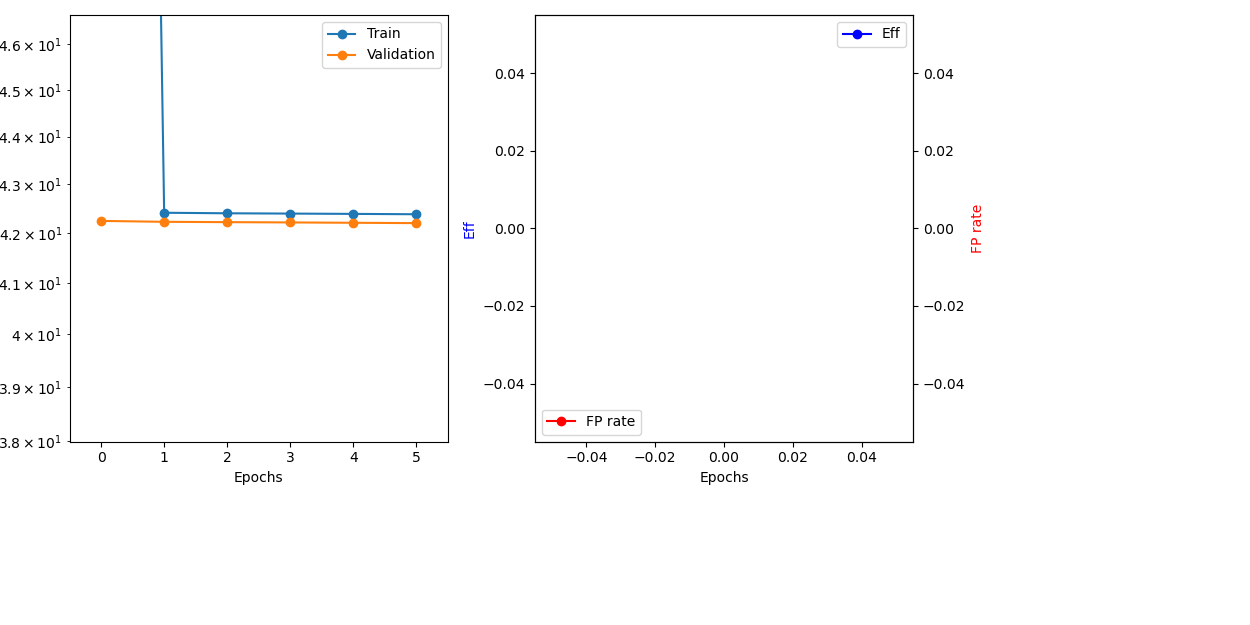

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

### Train the model

In [ ]:
# save initial model state
param_states.append(get_param_state(model))
torch.save(model.state_dict(), output / f'{name}_init.pyt')

for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start = len(results),
                        notebook = True,
                        ep_optimizer = ep_optimizer,
                        lr_scheduler = lr_scheduler,
                        careful = careful,
                        adaptive = adaptive
                      ):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))
    
# save final model and stats
torch.save(model.state_dict(), output / f'{name}_final.pyt')
results.to_hdf(f'{name}_stats.hdf5', 'results')

Number of batches: train = 1250, val = 157


Number of batches: train = 1250, val = 157


Epoch 0: train=284.418, val=42.2491, took 235.24 s


ADAPTIVE:
     dot: 1.000
     lr factor: 1.100
     lr changed to 5.499913066625595e-05
Epoch 1: train=42.4155, val=42.2305, took 241.62 s


ADAPTIVE:
     dot: 1.000
     lr factor: 1.100
     lr changed to 6.0498407105733424e-05
Epoch 2: train=42.4045, val=42.2238, took 247.24 s


ADAPTIVE:
     dot: 1.000
     lr factor: 1.100
     lr changed to 6.65470845252022e-05
Epoch 3: train=42.3984, val=42.218, took 242.24 s


ADAPTIVE:
     dot: 1.000
     lr factor: 1.100
     lr changed to 7.31987486772036e-05
Epoch 4: train=42.392, val=42.2108, took 245.66 s


ADAPTIVE:
     dot: 0.999
     lr factor: 1.100
     lr changed to 8.051243421381721e-05
Epoch 5: train=42.3848, val=42.2039, took 246.04 s


Save the plot above:

In [ ]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

### Plotting the angle grid, and the model outputs

In [ ]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 30
num_epochs = n_epochs

ep_intervals = [(np.arange(0, num_epochs+1, grid_size)[i], np.arange(0, num_epochs+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))